InstaDeep ML test <br>
Author: Mously Diaw

# Protein sequence classification

Proteins are sequence of amino acids, which can be encoded by a single letter. This project aims at building a deep learning model that assigns amino acid sequences to their protein family. The [Pfam dataset](https://www.kaggle.com/googleai/pfam-seed-random-split) is used for this task. 

1. [Dataset analysis](#section-one) <br>
2. [Classifier](#section-two) <br>
3. [Conclusion](#section-three) <br>

In [7]:
#Import packages
%matplotlib inline
import os
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import re
from keras.preprocessing.text import Tokenizer  
from keras.utils import to_categorical 
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Bidirectional, LSTM, Conv1D,Flatten 
from keras.layers import MaxPooling2D, GlobalMaxPooling2D , GRU, Conv1D

<a id="section-one"></a>
# 1. Dataset analysis 

## 1.1. Loading the data

In [8]:
def load_data(partition):
    data = []
    for fn in os.listdir(os.path.join(data_path, partition)):
        with open(os.path.join(data_path, partition, fn)) as f:
            data.append(pd.read_csv(f, index_col=None))
    return pd.concat(data) 

In [9]:
data_path = '../input/pfam-seed-random-split/random_split/random_split/'
df_train = load_data('train')
df_val = load_data('dev')
df_test = load_data('test')

In [10]:
print('Data size:')
print('Train size :', len(df_train))
print('Val size :', len(df_val))
print('Test size :', len(df_test))

Data size:
Train size : 1086741
Val size : 126171
Test size : 126171


In [11]:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,YfcL,Q5E3V0_VIBF1/3-85,PF08891.11,IEFEEKMLELIDARIESASD.DELFAGGYLRGHISLSVANCEEQGI...,IEFEEKMLELIDARIESASDDELFAGGYLRGHISLSVANCEEQGIN...
1,Somatomedin_B,F2UGX0_SALR5/258-297,PF01033.17,TTCAVRG...C..........SDINL......NQNCQCD.PSC.YS...,TTCAVRGCSDINLNQNCQCDPSCYSFGDCCADFAAVCESS
2,Surp,K7J3U9_NASVI/11-59,PF01805.20,RNIIDKLAQFVA..R..NG....P........EFEQMT.KNK.......,RNIIDKLAQFVARNGPEFEQMTKNKQKDNPKFSFLFGGEYFNYYQYKVT
3,DUF1230,E1ZG39_CHLVA/70-212,PF06799.11,.AVPREQRPVNELQQLKDTPLLAW......ATLDL..PQYAQRL.....,AVPREQRPVNELQQLKDTPLLAWATLDLPQYAQRLLILYGGVFLLL...
4,SRCR_2,F1NY88_CHICK/145-241,PF15494.6,GPNFILEVYSPVSQTWYPVCQDDWTDDFGKIACEDMGYN....VDT...,GPNFILEVYSPVSQTWYPVCQDDWTDDFGKIACEDMGYNVDTYYYS...


## 1.2. Exploratory data analysis (EDA) and data pre-processing

### 1.2.1. Preliminary processing and EDA

Let's first merge the data.

In [12]:
frames = [df_train, df_val, df_test]
df_full = pd.concat(frames)

We wish to predict *family_accession* given *sequence* so we will focus on these two attributes.

In [13]:
df = df_full[["family_accession","sequence"]]

In [14]:
print('Total number of unique protein families:',len(df.family_accession.unique()))

Total number of unique protein families: 17929


Since the train data set has over a million samples, we will first work with a subset of the data.  

In [102]:
df_train_small = df_train.iloc[0:89440][["family_accession","sequence"]]
print('Number of unique protein families in the small training set:',len(df_train_small.family_accession.unique()))

Number of unique protein families in the small training set: 13071


We will now compute the number of occurences of each amino acid and the length of the sequences in the training set.

In [103]:
# Count frequency amino acids
keys = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y','X', 'U', 'B', 'O', 'Z']

d = {key: 0 for key in keys}
for sequence in df_train_small.sequence:     
    for char in sequence: 
        d[char] = d[char] + 1 

# Order by frequency 
d_sorted = sorted(((d[key],key) for key in d), reverse =True) 

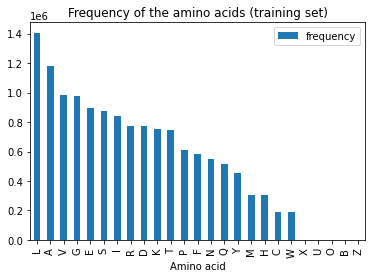

In [104]:
df_freq = pd.DataFrame(d_sorted, columns=['frequency', 'Amino acid'])
df_freq.plot(kind='bar', x='Amino acid')
plt.title("Frequency of the amino acids (training set)")
plt.show() 

We can see that there are 20 common amino acids. X,U,Z,B,O are the least frequent. 

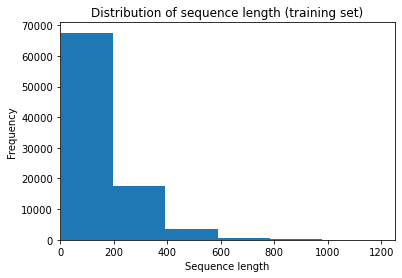

In [105]:
sequence_length = [len(sequence) for sequence in df_train_small.sequence]
plt.hist(sequence_length)
plt.xlabel('Sequence length')
plt.ylabel('Frequency')
plt.title('Distribution of sequence length (training set)') 
plt.xlim(0, 1250) 
plt.show()

The figure above shows that most of the sequences have less than 200 amino acids.  

### 1.2.2. Sequence processing 

Before feeding the data to a neural network, the sequences must be converted into tensors. We chose to tokenize the sequences by breaking them into characters. We then vectorize them (convert each character to a number) using a dictionary with the 20 most common amino acids; the 5 least frequent ones are affected the value '21'. After vectorization, we bring all sequences to the same length before one-hot encoding them. 

In [19]:
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1
    return char_dict

char_dict = create_dict(amino_acids)

print("Dictionary:", char_dict)

Dictionary: {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}


In [20]:
def vectorized_sequence(sequence):
    """
    Encodes the sequence using predefined dictionary. The 5 least frequent amino acids are affected the value '21'
    """
    code = []
    l = [char for char in sequence]
    for char in l:
        code.append(char_dict.get(char, 21))    
    return code   

Let's illustrate the process with the following sequence

In [106]:
idx=90
print("Amino acid sequence:",df_train_small.sequence.iloc[idx])

Amino acid sequence: ILIVGAGAIGGYFGGRLLQLGRDVTFLVRPGRAAELTRDGLVIKSPHGDATIQNPPAVQAAALTPDYDLVVLSCKAFDLDDAIASFRGGVGPRTAILPLLNGMKHLDVLDTAFGRDRVLGGQCVIAATLDAQRHVVQLAPMSAITFGERDG


In [107]:
vectorized_sequences = [vectorized_sequence(sequence) for sequence in df_train_small.sequence]  

In [108]:
print("Vectorized sequence:", vectorized_sequences[idx])

Vectorized sequence: [8, 10, 8, 18, 6, 1, 6, 1, 8, 6, 6, 20, 5, 6, 6, 15, 10, 10, 14, 10, 6, 15, 3, 18, 17, 5, 10, 18, 15, 13, 6, 15, 1, 1, 4, 10, 17, 15, 3, 6, 10, 18, 8, 9, 16, 13, 7, 6, 3, 1, 17, 8, 14, 12, 13, 13, 1, 18, 14, 1, 1, 1, 10, 17, 13, 3, 20, 3, 10, 18, 18, 10, 16, 2, 9, 1, 5, 3, 10, 3, 3, 1, 8, 1, 16, 5, 15, 6, 6, 18, 6, 13, 15, 17, 1, 8, 10, 13, 10, 10, 12, 6, 11, 9, 7, 10, 3, 18, 10, 3, 17, 1, 5, 6, 15, 3, 15, 18, 10, 6, 6, 14, 2, 18, 8, 1, 1, 17, 10, 3, 1, 14, 15, 7, 18, 18, 14, 10, 1, 13, 11, 16, 1, 8, 17, 5, 6, 4, 15, 3, 6]


In [109]:
maxlen = 200
padded_sequences = pad_sequences(vectorized_sequences , maxlen=maxlen, padding='post')

In [110]:
print("Padded sequence:", padded_sequences[idx])

Padded sequence: [ 8 10  8 18  6  1  6  1  8  6  6 20  5  6  6 15 10 10 14 10  6 15  3 18
 17  5 10 18 15 13  6 15  1  1  4 10 17 15  3  6 10 18  8  9 16 13  7  6
  3  1 17  8 14 12 13 13  1 18 14  1  1  1 10 17 13  3 20  3 10 18 18 10
 16  2  9  1  5  3 10  3  3  1  8  1 16  5 15  6  6 18  6 13 15 17  1  8
 10 13 10 10 12  6 11  9  7 10  3 18 10  3 17  1  5  6 15  3 15 18 10  6
  6 14  2 18  8  1  1 17 10  3  1 14 15  7 18 18 14 10  1 13 11 16  1  8
 17  5  6  4 15  3  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


In [111]:
oh_sequences = to_categorical(padded_sequences)

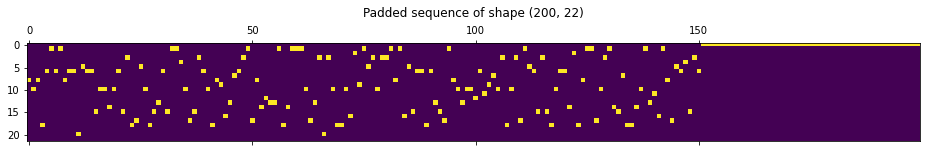

In [112]:
seq = oh_sequences[idx]
plt.matshow(seq.transpose())
plt.title("Padded sequence of shape %s" % (seq.shape,) + "\n")
plt.show()

In [113]:
X_train = oh_sequences

Finally we will transform the labels by one-hot encoding. 

In [114]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train_small.family_accession) 
y_train = to_categorical(y)
print("Shape of one-hot encoded class attribute: %s" % (y_train.shape,)) 

Shape of one-hot encoded class attribute: (89440, 13071)


<a id="section-two"></a>
# 2. Classifier 

Let's first build a baseline model.

In [129]:
input_shape = (200, 22)
num_classes = y_train.shape[1]  

In [130]:
model = Sequential([
    Flatten(input_shape=input_shape),  
    Dense(num_classes, activation ='softmax') 
]) 

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

To train the model, we will load the data in batches by creating a data iterator. 

In [119]:
class DataIterator:
    """ Collects data and yields bunch of batches of data
    Takes data sources and batch_size as arguments """
    def _init_(self, data1,data2, batch_size):
        self.data1 = data1
        self.data2 = data2
        self.batch_size = batch_size
        self.iter = self.make_random_iter()
    def next_batch(self):
        try:
            idxs = next(self.iter)
        except StopIteration:
            self.iter = self.make_random_iter()
            idxs = next(self.iter)
        X =[self.data1[i] for i in idxs]
        Y =[self.data2[i] for i in idxs]
        X = np.array(X)
        Y = np.array(Y)
        return X, Y
    def make_random_iter(self):
        splits = np.arange(self.batch_size, len(self.data1),self.batch_size)
        it = np.split(np.random.permutation(range(len(self.data1))), splits)[:-1]
        return iter(it)

In [131]:
train_iter = DataIterator() 
train_iter.data1 = X_train
train_iter.data2 = y_train
train_iter.batch_size = 64 
train_iter.iter = train_iter.make_random_iter()

In [143]:
step = 0
training_iters = np.floor(len(y_train)/batch_size) 
training_iters

1397.0

In [144]:
acc = []
loss = []
while   step  < training_iters:
        batch_x, batch_y = train_iter.next_batch()
        history = model.fit(batch_x, batch_y , epochs=1,batch_size=batch_size, verbose = False)
        acc.append(history.history['accuracy'])
        loss.append(history.history['loss'])
        step += 1
        print(step)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


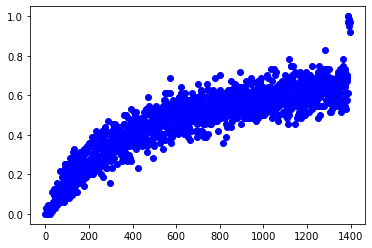

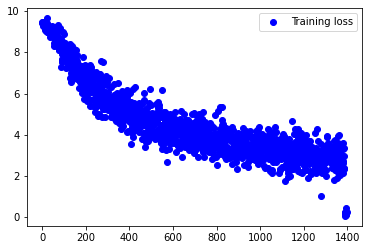

In [145]:
#epochs = range(1, len(acc) + 1)
plt.plot(acc, 'bo', label='Training acc')   
plt.figure() 
plt.plot(loss, 'bo', label='Training loss')  
plt.legend() 
plt.show() 


Evaluate model on validation set

In [146]:
vectorized_sequences_val = [vectorized_sequence(sequence) for sequence in df_val.sequence]  
padded_sequences_val = pad_sequences(vectorized_sequences_val , maxlen=maxlen, padding='post')
X_val = to_categorical(padded_sequences_val)

In [147]:
y = label_encoder.fit_transform(df_val.family_accession) 
y_val = to_categorical(y) 

In [148]:
results = model.evaluate(X_val , y_val , batch_size=64)
print("test loss, test acc:", results)

2/2 [==============================] - 0s 38ms/step - loss: 18.4198 - accuracy: 0.0234
test loss, test acc: [18.419776916503906, 0.0234375]


Evaluate model on test set

In [79]:
vectorized_sequences_test = [vectorized_sequence(sequence) for sequence in df_test.sequence]  
padded_sequences_test = pad_sequences(vectorized_sequences_test , maxlen=maxlen, padding='post')
X_test = to_categorical(padded_sequences_test)

In [80]:
y = label_encoder.fit_transform(df_test.family_accession) 
y_test = to_categorical(y) 

In [81]:
results = model.evaluate(X_test[0:128], y_test[0:128], batch_size=64)
print("test loss, test acc:", results)

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1177 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (64, 13071) and (64, 14182) are incompatible


<a id="section-three"></a>
# Conclusion
**^html link hidden here, fork notebook then click this cell to see it**

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Sed velit dignissim sodales ut eu sem integer vitae. Quam vulputate dignissim suspendisse in est ante. Arcu non odio euismod lacinia at. Etiam tempor orci eu lobortis. Egestas sed sed risus pretium quam vulputate dignissim suspendisse. Magna eget est lorem ipsum dolor sit amet consectetur adipiscing. Eget velit aliquet sagittis id consectetur purus ut faucibus. Egestas quis ipsum suspendisse ultrices gravida dictum fusce ut. Sed pulvinar proin gravida hendrerit. Dui faucibus in ornare quam viverra. Elit ullamcorper dignissim cras tincidunt lobortis feugiat vivamus. Enim diam vulputate ut pharetra sit amet aliquam. Nec feugiat in fermentum posuere urna nec tincidunt praesent. Elementum nisi quis eleifend quam adipiscing vitae proin sagittis. Malesuada proin libero nunc consequat interdum varius sit amet mattis. Urna neque viverra justo nec ultrices dui sapien. Adipiscing tristique risus nec feugiat in. Habitant morbi tristique senectus et netus et malesuada.